<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone: Credit Card Recommender

---
## Problem Statement
You've want to sign up for a credit card that best fits you, but you've realised that you will need to comb through all card descriptions, conditions and reviews in order to decide which card is the best. You find that it is very inconvenient and as a data scientist, you decide to take it upon yourself to build a credit card recommender.

Use different techniques to analyse the reviews, credit card conditions to derive a credit card recommender that could help to save a lot of time when choosing a credit card.

### Contents:
- [Background](#Background)
- [Datasets Used](#Datasets-Used)
- [Extraction of Data](#Extraction-of-Data)
- [Data Import & Cleaning](#Data-Import-and-Cleaning)
- [Data Dictionary](#Data-Dictionary)
- [Pre-processing text data](#Pre-processing-text-data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Sentiment Analysis Using BERT](#Sentiment-Analysis-Using-BERT)

## Background

All credit cards in Singapore offer some sort of reward for using them for your purchases, which include incentives like cashback, reward points (which can be traded for air miles, discount vouchers or actual products), or airline miles. However, the most common reward, and perhaps the most enticing, would perhaps be cashback.

For the uninitiated, cashback refers to receiving back a percentage of what you spend in the form of money. It is akin to getting a perpetual discount whenever you spend. Sounds too good to be true? It really is not. Credit card companies are constantly competing to provide the most competitive rewards for their customers - some cards offer lucrative sign-up promotions, while others offer higher cashbacks for niche spending categories like travel or sustainability.

With so many cards available on the market to choose from, it is no wonder that Singaporeans have a hard time deciding which is the best credit card in Singapore. In particular, it is hard to compare the different cashback rewards across multiple categories for various credit cards. [(source)](https://sg.news.yahoo.com/three-reasons-why-own-credit-104237659.html)

## Datasets Used

Data in this used in the analysis consists of credit card details and reviews scrapped from various websites. Please rerefer to the data dictionary for more information on the columns extracted.

## Extraction of Data

Please refer to "**1. Extraction of Data**" for the steps done for data extraction.

## Data Import and Cleaning

**1. Importing of libraries**

In [1]:
# Import libraries
import pandas as pd
import string
import re
import nltk
import numpy as np
import pandas as pd
import sklearn

# Chart plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image

# Modelling libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

**2. Importing of datasets being used**

We have imported the scraped_reviews dataset which we have extracted in "**1. Extraction of Data**".

In [2]:
# Import dataset:
scraped_reviews_df = pd.read_csv("../dataset/1. scraped_reviews_transposed.csv")
credit_card_type_df = pd.read_csv("../dataset/1. credit _card_type.csv")

**3. Display datasets**

In [3]:
# Display dataset
print(f'Scraped reviews dataset:')
display(scraped_reviews_df.head())

print(f'Credit Card Type dataset:')
display(credit_card_type_df.head())

Scraped reviews dataset:


,Unnamed: 0,reviews
0,standard-chartered-unlimited-cashback-credit-card,['My first credit card. One of the best cards ...
1,dbs-altitude-visa-signature-card,['Used to be my go-to general miles card but n...
2,uob-one-card,"['Cashback was still ok, used to be better but..."
3,posb-everyday-cashback,['POSB Everyday Card is a great option for fam...
4,dbs-womans-world-card,['An excellent card. One you should definitely...


Credit Card Type dataset:


,credit_card_name,card_type
0,standard-chartered-unlimited-cashback-credit-card,Cashback
1,dbs-altitude-visa-signature-card,Air Miles
2,uob-one-card,Cashback
3,posb-everyday-cashback,Cashback
4,dbs-womans-world-card,Air Miles


**4. Combine both datasets**

Combine both the card types dataset and reviews dataset into one single dataset.

In [4]:
# Rename Unnamed column to "credit_card_name"
scraped_reviews_df.rename(columns = {'Unnamed: 0': 'credit_card_name'}, inplace = True)

# Merge both datasets
combined_df = pd.merge(scraped_reviews_df, credit_card_type_df, how = 'inner')

# Display the merged dataset
display(combined_df.head())

# Show the total number of rows in the dataset
print(f'Rows, Columns: {combined_df.shape}')

,credit_card_name,reviews,card_type
0,standard-chartered-unlimited-cashback-credit-card,['My first credit card. One of the best cards ...,Cashback
1,dbs-altitude-visa-signature-card,['Used to be my go-to general miles card but n...,Air Miles
2,uob-one-card,"['Cashback was still ok, used to be better but...",Cashback
3,posb-everyday-cashback,['POSB Everyday Card is a great option for fam...,Cashback
4,dbs-womans-world-card,['An excellent card. One you should definitely...,Air Miles


Rows, Columns: (117, 3)


In [5]:
# Expand all the reviews and save them in a separate dataset
combined_expand_df = (combined_df.set_index(['credit_card_name', 'card_type']).
                      apply(lambda x: x.str.split('\',',).explode()).reset_index())     

# Display the expanded dataset
display(combined_expand_df.head())

# Show the total number of rows in the dataset
print(f'Rows, Columns: {combined_expand_df.shape}')

,credit_card_name,card_type,reviews
0,standard-chartered-unlimited-cashback-credit-card,Cashback,['My first credit card. One of the best cards ...
1,standard-chartered-unlimited-cashback-credit-card,Cashback,'A 1.5% no frill cashback cards. What i like ...
2,standard-chartered-unlimited-cashback-credit-card,Cashback,'[Fee Waivers]\n0 customer service. they will...
3,standard-chartered-unlimited-cashback-credit-card,Cashback,"""Fast application and ease of usage. Look out..."
4,standard-chartered-unlimited-cashback-credit-card,Cashback,'Super useful cashback card for basically any...


Rows, Columns: (1093, 3)


**5. Remove '\n' from the reviews column**

'\n' is being used in html to denote new paragraphs. Thus, we will have to remove them from the `reviews` column before we proceed with preprocessing.

In [6]:
# Define function to remove Newline
def remove_newline(text):
    tokens = re.split(r'\\n', text)
    for word in tokens:
        my_string = ' '.join(tokens)
    return my_string

combined_expand_df['reviews'] = combined_expand_df['reviews'].apply(lambda x: remove_newline(x))

# Display the expanded dataset after changes
display(combined_expand_df.head())

,credit_card_name,card_type,reviews
0,standard-chartered-unlimited-cashback-credit-card,Cashback,['My first credit card. One of the best cards ...
1,standard-chartered-unlimited-cashback-credit-card,Cashback,'A 1.5% no frill cashback cards. What i like ...
2,standard-chartered-unlimited-cashback-credit-card,Cashback,'[Fee Waivers] 0 customer service. they will ...
3,standard-chartered-unlimited-cashback-credit-card,Cashback,"""Fast application and ease of usage. Look out..."
4,standard-chartered-unlimited-cashback-credit-card,Cashback,'Super useful cashback card for basically any...


**6. Split the dataset into cashback and miles card type**

We will split the dataset into cashback and air miles so that we can perfom the analysis on the two different types of cards.

In [7]:
# Filter for cashback and save them in a cashback_expand dataset
cashback_expand_df = combined_expand_df[combined_expand_df['card_type'] == 'Cashback']
print(f'Cashback cards:')
display(cashback_expand_df.head())

# Show the total number of rows in the dataset
print(f'Rows, Columns: {cashback_expand_df.shape}')
print("\n")


# Filter for cashback and save them in a cashback_expand dataset
miles_expand_df = combined_expand_df[combined_expand_df['card_type'] == 'Air Miles']
print(f'Air Miles cards:')
display(miles_expand_df.head())

# Show the total number of rows in the dataset
print(f'Rows, Columns: {miles_expand_df.shape}')

Cashback cards:


,credit_card_name,card_type,reviews
0,standard-chartered-unlimited-cashback-credit-card,Cashback,['My first credit card. One of the best cards ...
1,standard-chartered-unlimited-cashback-credit-card,Cashback,'A 1.5% no frill cashback cards. What i like ...
2,standard-chartered-unlimited-cashback-credit-card,Cashback,'[Fee Waivers] 0 customer service. they will ...
3,standard-chartered-unlimited-cashback-credit-card,Cashback,"""Fast application and ease of usage. Look out..."
4,standard-chartered-unlimited-cashback-credit-card,Cashback,'Super useful cashback card for basically any...


Rows, Columns: (841, 3)


Air Miles cards:


,credit_card_name,card_type,reviews
121,dbs-altitude-visa-signature-card,Air Miles,['Used to be my go-to general miles card but n...
122,dbs-altitude-visa-signature-card,Air Miles,"'Great ""catch all"" miles card - use other 4MP..."
123,dbs-altitude-visa-signature-card,Air Miles,'Love this card with no expiry date of the DB...
124,dbs-altitude-visa-signature-card,Air Miles,'[Others] This card is one of the best entry-...
125,dbs-altitude-visa-signature-card,Air Miles,'I am an advocate of DBS. Their customer serv...


Rows, Columns: (252, 3)


Now that the cleaning portion is done, we will perform some pre-processing to prepare the data for analysis.

## Data Dictionary

<br>**Dataset name: `cashback_expand_df`**
<br>This dataset contains all the reviews on cashback credit cards.

| Feature | Type | Dataset | Description |
|:--|:-:|:-:|:--|
|credit_card_name|string|perfumes_df|Name of the credit card.|
|card_type|string|perfumes_df|Type of credit card. Cashback of Air Miles.|
|reviews|string|perfumes_df|Reviews on the credit cards.|


<br>**Dataset name: `miles_expand_df`**
<br>This dataset contains all the reviews on air miles credit cards.

| Feature | Type | Dataset | Description |
|:--|:-:|:-:|:--|
|credit_card_name|string|perfumes_df|Name of the credit card.|
|card_type|string|perfumes_df|Type of credit card. Cashback of Air Miles.|
|reviews|string|perfumes_df|Reviews on the credit cards.|

<br>**Dataset name: `combined_expand_df`**
<br>This dataset contains all the reviews on all credit cards.

| Feature | Type | Dataset | Description |
|:--|:-:|:-:|:--|
|credit_card_name|string|perfumes_df|Name of the credit card.|
|card_type|string|perfumes_df|Type of credit card. Cashback of Air Miles.|
|reviews|string|perfumes_df|Reviews on the credit cards.|

## Pre-processing text data

Now we will clean the text data so that we can perform analysis on the datasets.

**1. Remove punctuations**

Remove the punctuations as these are not required in text analysis.

In [8]:
# Create a copy of the combined_expand_df
combined_analyse_df = combined_expand_df.copy()

# Define function to remove punctuation
def remove_punct(text):
    # store character only if it is not a punctuation
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

# Remove punctuation from the 'title and selftext' column
combined_analyse_df['reviews_clean'] = combined_analyse_df['reviews'].apply(lambda x: remove_punct(x))

# Display the dataset after the changes
display(combined_analyse_df.head())

,credit_card_name,card_type,reviews,reviews_clean
0,standard-chartered-unlimited-cashback-credit-card,Cashback,['My first credit card. One of the best cards ...,My first credit card One of the best cards for...
1,standard-chartered-unlimited-cashback-credit-card,Cashback,'A 1.5% no frill cashback cards. What i like ...,A 15 no frill cashback cards What i like abou...
2,standard-chartered-unlimited-cashback-credit-card,Cashback,'[Fee Waivers] 0 customer service. they will ...,Fee Waivers 0 customer service they will not ...
3,standard-chartered-unlimited-cashback-credit-card,Cashback,"""Fast application and ease of usage. Look out...",Fast application and ease of usage Look out f...
4,standard-chartered-unlimited-cashback-credit-card,Cashback,'Super useful cashback card for basically any...,Super useful cashback card for basically anyt...


**2. Tokenization**

Split the text into smaller pieces, ie. single words.

In [9]:
# Define function to tokenize the column
def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

# Tokenize the 'title and selftext' column
combined_analyse_df['reviews_tokenized'] = combined_analyse_df['reviews_clean'].apply(
    lambda x: tokenize(x.lower()))

# Display the dataset after the changes
display(combined_analyse_df.head())

,credit_card_name,card_type,reviews,reviews_clean,reviews_tokenized
0,standard-chartered-unlimited-cashback-credit-card,Cashback,['My first credit card. One of the best cards ...,My first credit card One of the best cards for...,"[my, first, credit, card, one, of, the, best, ..."
1,standard-chartered-unlimited-cashback-credit-card,Cashback,'A 1.5% no frill cashback cards. What i like ...,A 15 no frill cashback cards What i like abou...,"[, a, 15, no, frill, cashback, cards, what, i,..."
2,standard-chartered-unlimited-cashback-credit-card,Cashback,'[Fee Waivers] 0 customer service. they will ...,Fee Waivers 0 customer service they will not ...,"[, fee, waivers, 0, customer, service, they, w..."
3,standard-chartered-unlimited-cashback-credit-card,Cashback,"""Fast application and ease of usage. Look out...",Fast application and ease of usage Look out f...,"[, fast, application, and, ease, of, usage, lo..."
4,standard-chartered-unlimited-cashback-credit-card,Cashback,'Super useful cashback card for basically any...,Super useful cashback card for basically anyt...,"[, super, useful, cashback, card, for, basical..."


**3. Remove stopwords**

Remove the words that have very little meaning as these words are not going to be helpful in our analysis.

In [10]:
# Obtain stopwords from the NLTK(Natural Language Toolkit) in Python
stopword = nltk.corpus.stopwords.words('english')

# Define function to remove stop words
def remove_stopwords(tokenized_list):
    # Store in text only if word is not found in stopword i.e. it is not a stopword
    text = [word for word in tokenized_list if word not in stopword]
    return text

# Remove stopwords from the 'title and selftext' column
combined_analyse_df['reviews_no_stop'] = combined_analyse_df['reviews_tokenized'].apply(lambda x: remove_stopwords(x))

# Display the dataset after the changes
display(combined_analyse_df.head())

,credit_card_name,card_type,reviews,reviews_clean,reviews_tokenized,reviews_no_stop
0,standard-chartered-unlimited-cashback-credit-card,Cashback,['My first credit card. One of the best cards ...,My first credit card One of the best cards for...,"[my, first, credit, card, one, of, the, best, ...","[first, credit, card, one, best, cards, cash, ..."
1,standard-chartered-unlimited-cashback-credit-card,Cashback,'A 1.5% no frill cashback cards. What i like ...,A 15 no frill cashback cards What i like abou...,"[, a, 15, no, frill, cashback, cards, what, i,...","[, 15, frill, cashback, cards, like, seems, le..."
2,standard-chartered-unlimited-cashback-credit-card,Cashback,'[Fee Waivers] 0 customer service. they will ...,Fee Waivers 0 customer service they will not ...,"[, fee, waivers, 0, customer, service, they, w...","[, fee, waivers, 0, customer, service, waive, ..."
3,standard-chartered-unlimited-cashback-credit-card,Cashback,"""Fast application and ease of usage. Look out...",Fast application and ease of usage Look out f...,"[, fast, application, and, ease, of, usage, lo...","[, fast, application, ease, usage, look, promo..."
4,standard-chartered-unlimited-cashback-credit-card,Cashback,'Super useful cashback card for basically any...,Super useful cashback card for basically anyt...,"[, super, useful, cashback, card, for, basical...","[, super, useful, cashback, card, basically, a..."


**4. Lemmatization**

Convert the words into their most basic forms for analysis.

In [11]:
## Instantiate the function
wn = nltk.WordNetLemmatizer()

# Define function for lemmatization
def lemmatizing(tokenized_text):
    text = []
    # return list of all lemmatized words for their corresponding words in tokenized_text
    for word in tokenized_text:
        # Treat 'spending' as a verb instead of a noun
        if word.startswith('spend'):
            text.append(wn.lemmatize(word,nltk.corpus.wordnet.VERB))
        # Do not lemmatize the word dbs
        elif word.startswith('dbs'):
            text.append(word)
        else:
            text.append(wn.lemmatize(word))
    return text

# Lemmatize the 'title and selftext' column
combined_analyse_df['reviews_lemmatized'] = combined_analyse_df['reviews_no_stop'].apply(
    lambda x: lemmatizing(x))

# Display the first few rows in the datset
display(combined_analyse_df.head())

,credit_card_name,card_type,reviews,reviews_clean,reviews_tokenized,reviews_no_stop,reviews_lemmatized
0,standard-chartered-unlimited-cashback-credit-card,Cashback,['My first credit card. One of the best cards ...,My first credit card One of the best cards for...,"[my, first, credit, card, one, of, the, best, ...","[first, credit, card, one, best, cards, cash, ...","[first, credit, card, one, best, card, cash, b..."
1,standard-chartered-unlimited-cashback-credit-card,Cashback,'A 1.5% no frill cashback cards. What i like ...,A 15 no frill cashback cards What i like abou...,"[, a, 15, no, frill, cashback, cards, what, i,...","[, 15, frill, cashback, cards, like, seems, le...","[, 15, frill, cashback, card, like, seems, le,..."
2,standard-chartered-unlimited-cashback-credit-card,Cashback,'[Fee Waivers] 0 customer service. they will ...,Fee Waivers 0 customer service they will not ...,"[, fee, waivers, 0, customer, service, they, w...","[, fee, waivers, 0, customer, service, waive, ...","[, fee, waiver, 0, customer, service, waive, l..."
3,standard-chartered-unlimited-cashback-credit-card,Cashback,"""Fast application and ease of usage. Look out...",Fast application and ease of usage Look out f...,"[, fast, application, and, ease, of, usage, lo...","[, fast, application, ease, usage, look, promo...","[, fast, application, ease, usage, look, promo..."
4,standard-chartered-unlimited-cashback-credit-card,Cashback,'Super useful cashback card for basically any...,Super useful cashback card for basically anyt...,"[, super, useful, cashback, card, for, basical...","[, super, useful, cashback, card, basically, a...","[, super, useful, cashback, card, basically, a..."


**5. Count Vectorizer**

Convert text data into a structured, numeric X dataframe by using CountVectorizer.

In [12]:
def countvec_check(value):
    # Create an instance of CountVectorizer and pass in the clean_text function as the analyzer parameter
    count_vect = CountVectorizer(analyzer = lemmatizing)

    # X_counts stores the vectorized version of the data
    X_counts = count_vect.fit_transform(value)

    # Returns the number of rows and columns of X_counts
    print(f'R(Rows, Columns): {X_counts.shape}')

    # Returns the unique words across all text messages
    print(count_vect.get_feature_names())

print(countvec_check(combined_analyse_df['reviews_no_stop']))

R(Rows, Columns): (1093, 3628)
['', '0', '01', '019', '03', '034', '05', '07', '083', '1', '10', '100', '1000', '10000', '10000miles', '1000month', '1001000', '105', '10k', '10points', '10x', '10x4mpd', '11', '117', '11am', '12', '120', '1200', '12243', '125mth', '12am', '12k', '12mdp', '12miles', '12month', '12mpd', '12mpd2mpd', '13', '130000', '138', '13k', '14', '14mpd', '15', '150', '1500', '15k', '15mins', '15th', '16', '16k', '17', '18', '180', '1800', '185', '18k', '19', '192', '1for1', '1k', '1k2k', '1st', '1x', '1x04mpd', '1year', '2', '20', '200', '2000', '2000month', '2000mth', '2009', '201', '20100', '2011', '2013', '2017', '2018', '2019', '2020', '2021', '2024', '2030', '20mins', '20x', '20x8mpd', '21', '210', '218', '2230', '23', '23days', '24', '247', '25', '250', '2500', '27', '27k', '28', '29', '2k', '2miles', '2mpd', '2nd', '2th', '2x', '3', '30', '300', '3000', '30000', '3002000', '300quarter', '30800', '30each', '30k', '30th', '31', '31st', '325', '33', '330', '333'

Now we have a count matrix with 4,621 unique words. Now we are ready to do some Exploratory Data Analysis! Let's look at the top words found in each card type.

## Exploratory Data Analysis

**1. Most Common Two-Word and Three-Word phrases**

**1.1. Count Vectorizer (N-Grams for Cashback dataset)**

In [13]:
# Filter combined_df for "Perfumes"
cashback_analyse_df = combined_analyse_df[combined_analyse_df['card_type'] == 'Cashback']

# Filter combined_df for "Makeup"
miles_analyse_df = combined_analyse_df[combined_analyse_df['card_type'] == 'Air Miles']

In [14]:
# Define function to find top words
def top_words(value, num):
    return value.sum().sort_values(ascending = False).head(num)

# Define function for N-Gram lemmatization
def lemmatizing_ngram(tokenized_text):
    # return string of all lemmatized words for their corresponding words in tokenized_text
    text_list = []
    # return list of all lemmatized words for their corresponding words in tokenized_text
    for word in tokenized_text:
        # Treat 'spending' as a verb instead of a noun
        if word.startswith('spend'):
            text_list.append(wn.lemmatize(word,nltk.corpus.wordnet.VERB))
        # Do not lemmatize the word dbs
        elif word.startswith('dbs'):
            text_list.append(word)
        else:
            text_list.append(wn.lemmatize(word))
    my_string = ' '.join(text_list)
    return my_string

# Define function to create sparsematrix for N-Gram
def sparsematrix_ngram_check(value, num):
    # Create a ngram
    ngram_vect = CountVectorizer(ngram_range=(num,num))

    # X_counts stores the vectorized version of the data
    X_counts = ngram_vect.fit_transform(value)
    
    # Expand sparse matrix to a collection of arrays and then store it in a data frame
    X_counts_df = pd.DataFrame(X_counts.toarray())
    
    # Apply column name to the dataframe
    X_counts_df.columns = ngram_vect.get_feature_names()
    
    return X_counts_df

# Lemmatize the 'title and selftext' column
cashback_analyse_df['reviews_lemmatized'] = cashback_analyse_df['reviews_no_stop'].apply(
    lambda x: lemmatizing_ngram(x))

# Save bigram sparse matrix as combined_df_ngram
cashback_analyse_df_bigram = sparsematrix_ngram_check(cashback_analyse_df['reviews_lemmatized'], 2)

# Returns the number of rows and columns of X_counts
print('Total number of rows and columns:')
print(f'(Rows, Columns): {cashback_analyse_df_bigram.shape}')

Total number of rows and columns:
(Rows, Columns): (841, 16429)


There are a total of 17,169 unqiue two-word phrases in the Cashback dataset. Let's look at the top 20 phrases.

**Bigram - Cashback**

In [15]:
# Print top 20 BiGram words for Cashback dataset
print('Top 20 BiGram words for Cashback dataset')
print(top_words(cashback_analyse_df_bigram,20).to_string())

Top 20 BiGram words for Cashback dataset
credit card           228
cashback card         207
minimum spend         178
cash back             133
customer service      132
fee waiver            116
cash rebate            77
annual fee             71
use card               69
promotion perk         61
min spend              56
uob one                52
using card             50
15 cashback            48
card use               43
per month              40
everyday card          39
good card              39
dbs multiplier         39
multiplier account     37


Words such as "minimum spend", "customer service", "fee waiver", "promotion perk", and "annual fee" have appeared in the top 20 words. These words refer to the things that customers look out for when choosing credit cards. It seems like UOB One and DBS Everyday Cards are the most mentioned cards.

Now, lets take a look at the three-word phrases.

**Trigram - Cashback**

In [16]:
# Save trigram sparse matrix as combined_df_ngram
cashback_analyse_df_trigram = sparsematrix_ngram_check(cashback_analyse_df['reviews_lemmatized'], 3)

# Returns the number of rows and columns of X_counts
print('Total number of rows and columns:')
print(f'(Rows, Columns): {cashback_analyse_df_trigram.shape}')

Total number of rows and columns:
(Rows, Columns): (841, 21708)


There are a total of 21,896 unqiue three-word phrases in the Cashback dataset. Let's look at the top 20 phrases.

In [17]:
# Print top 20 TriGram words for Cashback dataset
print('Top 20 TriGram words for Cashback dataset')
print(top_words(cashback_analyse_df_trigram,20).to_string())

Top 20 TriGram words for Cashback dataset
dbs multiplier account    24
posb everyday card        24
uob one account           20
uob one card              18
cash back card            18
minimum spend required    18
card minimum spend        17
annual fee waiver         17
minimum spend 600         16
cashback minimum spend    15
dbs live fresh            15
credit card spend         14
ocbc 360 account          13
hit minimum spend         12
credit card bill          12
waive annual fee          11
good credit card          11
one best card             10
higher interest rate      10
cashback card cashback    10


In the top 20 three-word phrases, we also see words such as 'minimum spend required', 'cashback minimum spend' and 'minimimum spend 600'. It seems like customers are the most concerned about minimum spending requirements for the cards. The most mentioned cards here are the DBS and UOB cards, as they affect the interest rates of their savings accounts.

**1.2. Visualise our findings for Cashback dataset**

Now, let's visualise our findings from the Cashback dataset.

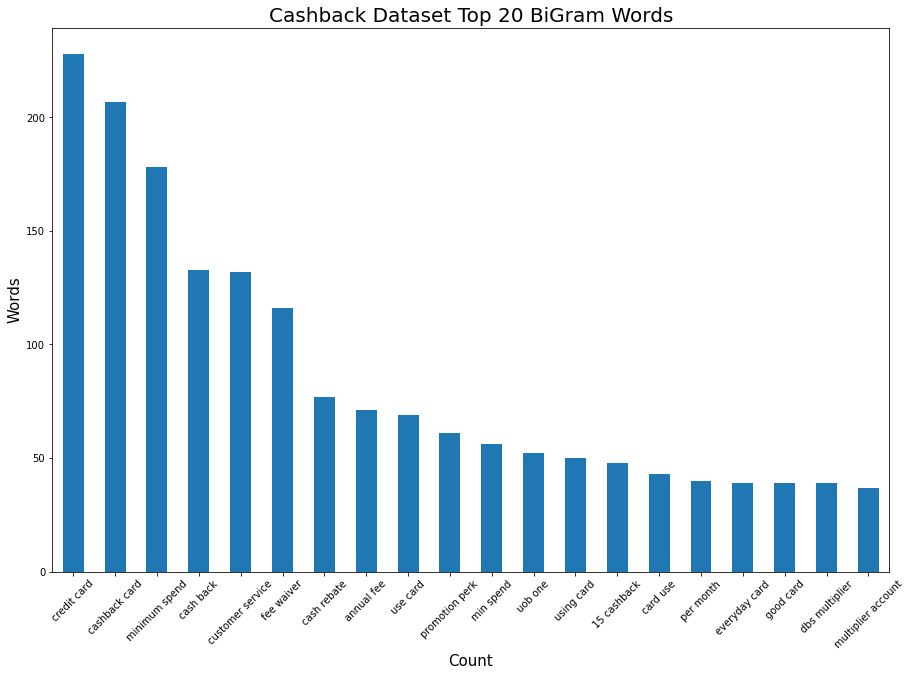

In [18]:
# Plot BiGram barchart

# Convert the top word count to a dataframe
top_words_cashback_bigram = top_words(cashback_analyse_df_bigram, 20).to_frame()

# Plot the top 20 words in a bar chart
cashback_bigram = top_words_cashback_bigram.plot(kind = 'bar', figsize = (15,10), fontsize = 10, width = 0.5)

# Set the title, x & y labels and remove legend
cashback_bigram.set_title('Cashback Dataset Top 20 BiGram Words', fontsize=20)
cashback_bigram.get_legend().remove()
cashback_bigram.set_ylabel('Words', fontsize=15)
cashback_bigram.set_xlabel('Count', fontsize=15)
plt.xticks(rotation=45);

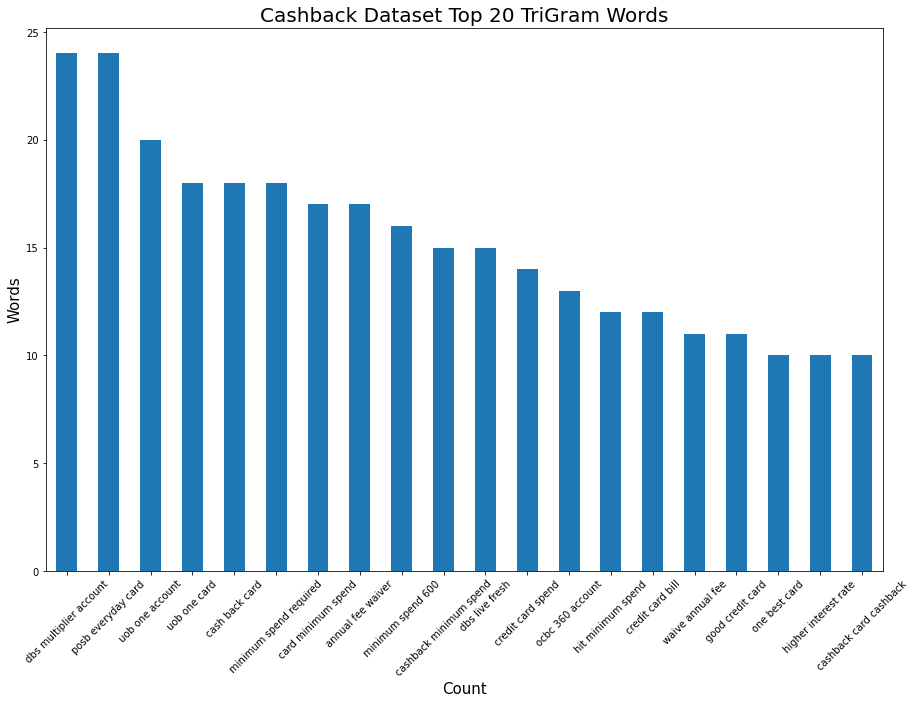

In [19]:
# Plot TriGram barchart

# Convert the top word count to a dataframe
top_words_cashback_trigram = top_words(cashback_analyse_df_trigram, 20).to_frame()

# Plot the top 20 words in a bar chart
cashback_trigram = top_words_cashback_trigram.plot(kind = 'bar', figsize = (15,10), fontsize = 10, width = 0.5)

# Set the title, x & y labels and remove legend
cashback_trigram.set_title('Cashback Dataset Top 20 TriGram Words', fontsize=20)
cashback_trigram.get_legend().remove()
cashback_trigram.set_ylabel('Words', fontsize=15)
cashback_trigram.set_xlabel('Count', fontsize=15)
plt.xticks(rotation=45);

Now, let's look at the top 20 two-word and three-word phrases for the Air Miles dataset.

**1.3. Count Vectorizer (N-Grams for Air Miles dataset)**

In [20]:
# Lemmatize the 'title and selftext' column
miles_analyse_df['reviews_lemmatized'] = miles_analyse_df['reviews_no_stop'].apply(
    lambda x: lemmatizing_ngram(x))

# Save bigram sparse matrix as combined_df_ngram
miles_analyse_df_bigram = sparsematrix_ngram_check(miles_analyse_df['reviews_lemmatized'], 2)

# Returns the number of rows and columns of X_counts
print('Total number of rows and columns:')
print(f'(Rows, Columns): {miles_analyse_df_bigram.shape}')

Total number of rows and columns:
(Rows, Columns): (252, 6336)


There are a total of 6,559 unqiue two-word phrases in the Air Miles dataset. Let's look at the top 20 phrases.

**Bigram - Air Miles**

In [21]:
# Print top 20 BiGram words for Air Miles dataset
print('Top 20 BiGram words for Air Miles dataset')
print(top_words(miles_analyse_df_bigram,20).to_string())

Top 20 BiGram words for Air Miles dataset
mile card           85
credit card         57
mile per            42
fee waiver          42
customer service    41
per dollar          40
annual fee          39
great card          22
using card          22
promotion perk      20
card mile           19
dbs point           19
mile expire         19
sign bonus          17
one best            16
lounge access       16
general spend       16
online purchase     15
priority pas        15
use card            14


Similarly, words such as 'fee waiver', 'customer serivice', 'annual fees' and 'sign bonus' are among the top few words. These are some the things that customers look out for when signing new credit cards. Customers also look out how many miles they can get per dollar spent and how long it takes for their miles to expire. Once again, DBS cards can be found in the top 20 two-word prhases.

Now, lets take a look at the three-word phrases.

**Trigram - Air Miles**

In [22]:
# Save trigram sparse matrix as combined_df_ngram
miles_analyse_df_trigram = sparsematrix_ngram_check(miles_analyse_df['reviews_lemmatized'], 3)

# Returns the number of rows and columns of X_counts
print('Total number of rows and columns:')
print(f'(Rows, Columns): {miles_analyse_df_trigram.shape}')

Total number of rows and columns:
(Rows, Columns): (252, 7745)


There are a total of 7,745 unqiue three-word phrases in the Air Miles dataset. Let's look at the top 20 phrases.

In [23]:
# Print top 20 TriGram words for Air Miles dataset
print('Top 20 TriGram words for Air Miles dataset')
print(top_words(miles_analyse_df_trigram,20).to_string())

Top 20 TriGram words for Air Miles dataset
mile per dollar             35
best mile card               8
waive annual fee             7
per dollar spent             6
dbs lifestyle app            6
mile card one                6
general spend card           6
12 mile per                  6
woman world card             6
must credit card             5
credit card accumulating     5
airport lounge access        5
mile never expire            5
point dont expire            5
pay annual fee               5
card accumulating mile       5
mile dont expire             5
card one best                5
one must credit              5
card great card              5


In the top 20 three-word phrases, we also see words such as 'waive annual fee', 'pay annual fee', 'miles dont expire', 'point dont expire', 'mile never expire'. It seems like customers are the most concerned about annual fee for the card and whether the files expired or not. The most mentioned cards here are the DBS cards.

**1.4. Visualise our findings for Air Miles dataset**

Now, let's visualise our findings from the Cashback dataset.

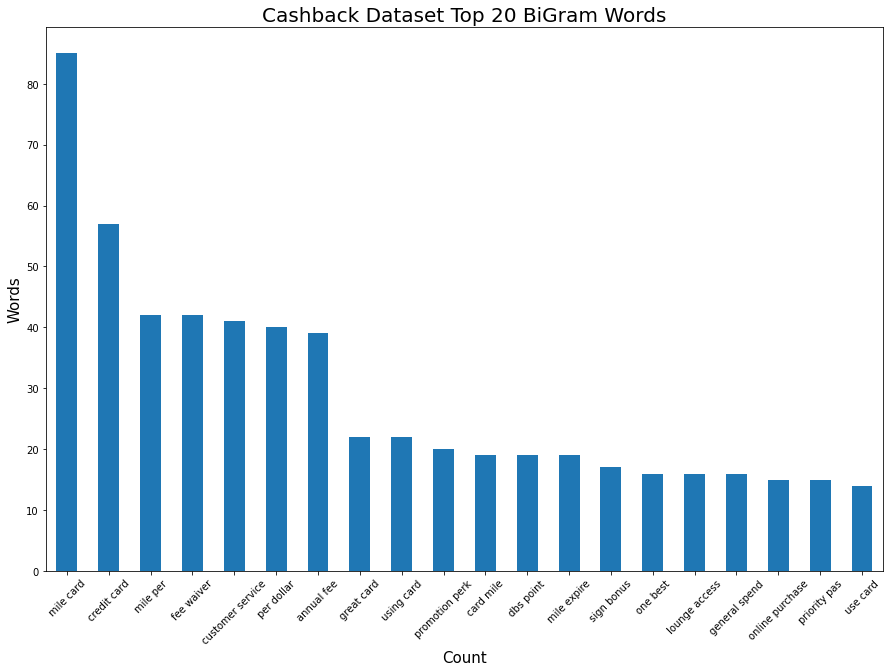

In [24]:
# Plot BiGram barchart

# Convert the top word count to a dataframe
top_words_miles_bigram = top_words(miles_analyse_df_bigram, 20).to_frame()

# Plot the top 20 words in a bar chart
miles_bigram = top_words_miles_bigram.plot(kind = 'bar', figsize = (15,10), fontsize = 10, width = 0.5)

# Set the title, x & y labels and remove legend
miles_bigram.set_title('Cashback Dataset Top 20 BiGram Words', fontsize=20)
miles_bigram.get_legend().remove()
miles_bigram.set_ylabel('Words', fontsize=15)
miles_bigram.set_xlabel('Count', fontsize=15)
plt.xticks(rotation=45);

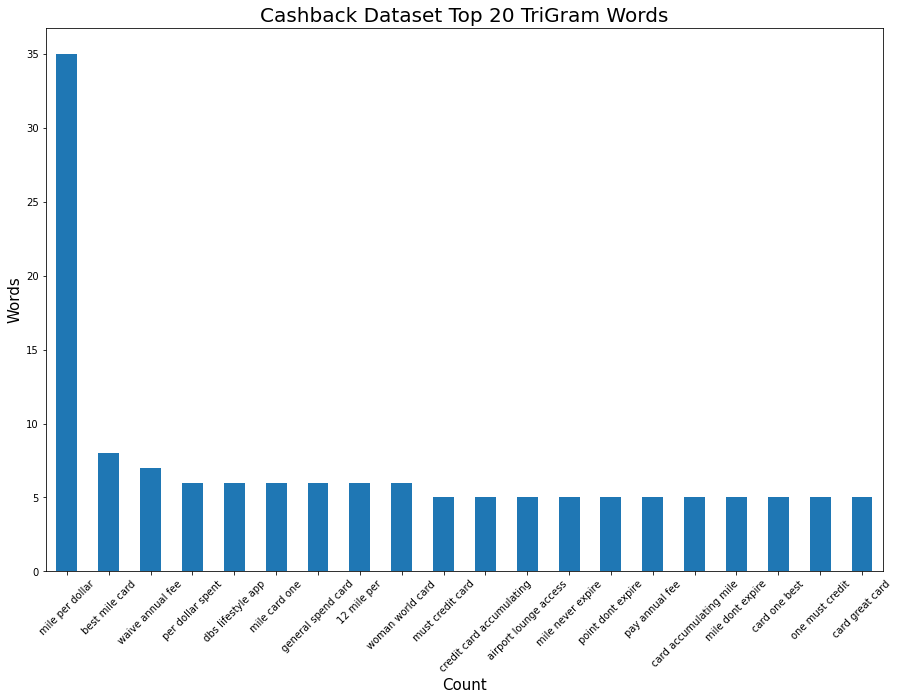

In [25]:
# Plot TriGram barchart

# Convert the top word count to a dataframe
top_words_miles_trigram = top_words(miles_analyse_df_trigram, 20).to_frame()

# Plot the top 20 words in a bar chart
miles_trigram = top_words_miles_trigram.plot(kind = 'bar', figsize = (15,10), fontsize = 10, width = 0.5)

# Set the title, x & y labels and remove legend
miles_trigram.set_title('Cashback Dataset Top 20 TriGram Words', fontsize=20)
miles_trigram.get_legend().remove()
miles_trigram.set_ylabel('Words', fontsize=15)
miles_trigram.set_xlabel('Count', fontsize=15)
plt.xticks(rotation=45);

Now that we have taken took at the two-Words and three-Words phrases, let's gather some insights by taking a look at the most common words.

**2. Most Common Words**

Let's find the top 20 words for each subreddit.

**2.1. Most Common Words in Cashback dataset**

In [26]:
# Define function for sparse matrix
def sparsematrix_check(value):
    # Create an instance of CountVectorizer and pass in the clean_text function as the analyzer parameter
    count_vect = CountVectorizer(analyzer = lemmatizing)

    # X_counts stores the vectorized version of the data
    X_counts = count_vect.fit_transform(value)
    
    # Expand sparse matrix to a collection of arrays and then store it in a data frame
    X_counts_df = pd.DataFrame(X_counts.toarray())
    
    # Apply column name to the dataframe
    X_counts_df.columns = count_vect.get_feature_names()
    
    return X_counts_df

# Create sparse_matrix for both perfumes and makeup
cashback_sparse_matrix = sparsematrix_check(cashback_analyse_df['reviews_no_stop'])
miles_sparse_matrix = sparsematrix_check(miles_analyse_df['reviews_no_stop'])

In [27]:
# Define function to find top words
def top_words(value, num):
    return value.sum().sort_values(ascending = False).head(num)

# Find the top 50 words in Cashback dataset
print('Top 50 words in Cashback dataset:')
print("")
print(top_words(cashback_sparse_matrix, 50).to_string())

Top 50 words in Cashback dataset:

card           1618
               1128
cashback        764
spend           709
rebate          393
use             293
good            291
month           257
credit          255
cash            235
minimum         227
fee             224
get             220
one             206
back            181
online          172
customer        172
service         166
account         165
promotion       148
waiver          142
using           141
purchase        137
bill            134
best            131
also            131
category        121
like            119
great           118
useful          111
15              110
5               110
dbs             107
easy            107
3               106
bank            106
payment         102
ocbc            101
used             99
transaction      98
year             94
grocery          92
1                91
time             91
hit              90
interest         89
perk             89
give             88
first

Noted that there are further stopwords like spaces, '5', '15', '3', '1' etc that doesn't really make sense. As such we will remove these words from the `cashback_analyse_df` dataset. 

From the top 50 words, we will try to identify and remove as many stop words as possible. After that, we will look at the revised top 20 words to make sure that all of the stopwords have been removed from the list.

**2.2. Remove Further Stopwords from the Cashback Dataset**

In [28]:
# Define function to remove stop words
def remove_further_stopwords(tokenized_list, stopword_list):
    # Store in text only if word is not found in stopword i.e. it is not a stopword
    text = [word for word in tokenized_list if word not in stopword_list]
    return text

# List the words that we want to remove
stopwords_cashback = ['', '5', '1', '3', '15', 'use', 'get', 'one', 'card', 'back', 'good', 'using', 'also', 'like']

# Remove stopwords from the 'title and selftext' column
cashback_analyse_df['reviews_no_stop'] = cashback_analyse_df['reviews_no_stop'].apply(
    lambda x: remove_further_stopwords(x, stopwords_cashback))

# Recreate the sparse matrix for Makeup subreddit
cashback_sparse_matrix = sparsematrix_check(cashback_analyse_df['reviews_no_stop'])

# Display the new top 20 words after the change
print('Top 20 words in Cashback dataset (Revised):')
print("")
print(top_words(cashback_sparse_matrix, 20).to_string())

Top 20 words in Cashback dataset (Revised):

cashback     764
spend        709
rebate       393
month        257
credit       255
cash         235
minimum      227
fee          224
customer     172
online       172
card         167
service      166
account      165
promotion    148
waiver       142
purchase     137
bill         134
best         131
category     121
great        118


After removing further stopwords, the top 20 words seems to make more sense now. From my the looks of this. The most common topics seems to be about the rebates, the minimum spending and fee waiver. 

Now, let's visualise our above findings.

**2.3. Visualise our findings for the Cashback Dataset**

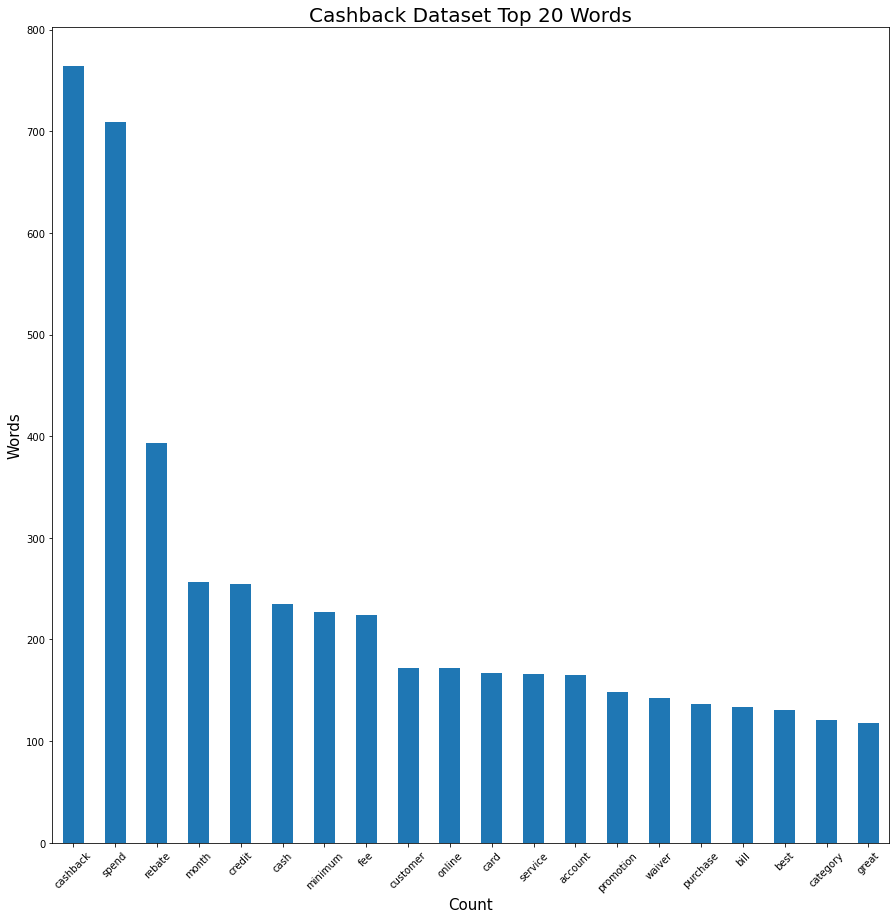

In [29]:
# Convert the top word count to a dataframe
top_words_cashback = top_words(cashback_sparse_matrix, 20).to_frame()

# Plot the top 20 words in a bar chart
cashback_bar = top_words_cashback.plot(kind = 'bar', figsize = (15,15), fontsize = 10, width = 0.5)

# Set the title, x & y labels and remove legend
cashback_bar.set_title('Cashback Dataset Top 20 Words', fontsize=20)
cashback_bar.get_legend().remove()
cashback_bar.set_ylabel('Words', fontsize=15)
cashback_bar.set_xlabel('Count', fontsize=15)
plt.xticks(rotation=45);

In [30]:
# Lemmatize the 'title and selftext' column in the perfumes_df_cleaned dataset
cashback_analyse_df['reviews_lemmatized'] = cashback_analyse_df['reviews_no_stop'].apply(
    lambda x: lemmatizing(x))

# Concatenate all the words in the 'title_and_selftext_lemmatized' column to string
cashback_analyse_df['reviews_string'] = cashback_analyse_df['reviews_lemmatized'].apply(
    lambda x: ' '.join(x))

# Create a mask for the word cloud
cashback_mask = np.array(Image.open('../image/Dollar.png'))

# Generate a word cloud
wc = WordCloud(background_color="white", colormap="tab10", max_font_size=150, mask = cashback_mask)

wcloud = wc.generate(' '.join(cashback_analyse_df['reviews_string']))

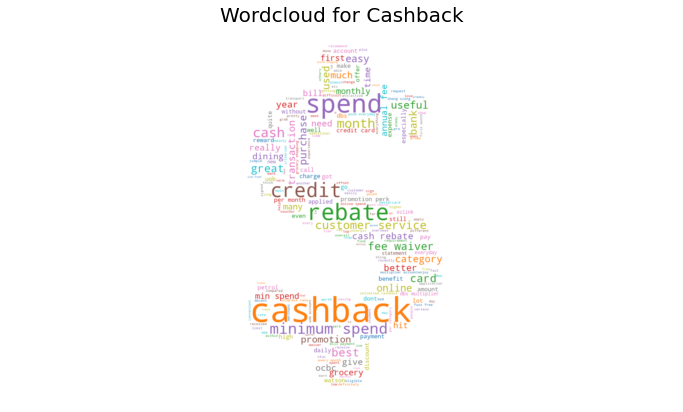

In [31]:
# Make figure to plot
plt.figure(figsize = (12,12))

# plot words
plt.imshow(wcloud, interpolation="bilinear")

# remove axes
plt.title("Wordcloud for Cashback", fontsize = 20)

# remove axes
plt.axis("off")

# save chart as png
plt.savefig('../image/cashback_wordcloud.png', transparent = True, bbox_inches = 'tight')

# show the result
plt.show()

**2.4. Most Common Words in Air Miles dataset**

In [32]:
# Find the top 50 words in Air Miles dataset
print('Top 50 words in Air Miles dataset:')
print("")
print(top_words(miles_sparse_matrix, 50).to_string())

Top 50 words in Air Miles dataset:

card           521
mile           415
               322
spend          140
point          110
fee             96
online          92
per             81
dbs             80
good            79
use             78
get             71
one             65
credit          63
best            61
promotion       59
reward          59
expire          56
year            56
great           54
using           54
2               53
service         52
waiver          50
dollar          49
customer        48
earn            47
bonus           45
also            45
annual          43
month           43
purchase        43
transaction     42
time            41
1               40
lounge          39
rate            37
travel          35
free            33
4mpd            32
easy            31
3               31
dont            30
sign            30
first           29
give            29
call            28
perk            27
general         27
apply           27


Noted that there are further stopwords like spaces, '2', '1', etc that doesn't really make sense. As such we will remove these words from the `miles_analyse_df` dataset. 

From the top 50 words, we will try to identify and remove as many stop words as possible. After that, we will look at the revised top 20 words to make sure that all of the stopwords have been removed from the list.

**2.5. Remove Further Stopwords from the Air Miles Dataset**

In [33]:
# Define function to remove stop words
def remove_further_stopwords(tokenized_list, stopword_list):
    # Store in text only if word is not found in stopword i.e. it is not a stopword
    text = [word for word in tokenized_list if word not in stopword_list]
    return text

# List the words that we want to remove
stopwords_cashback = ['', 'credit', 'card', 'one', '1', '2', 'per', 'get', 'use', '3']

# Remove stopwords from the 'title and selftext' column
miles_analyse_df['reviews_no_stop'] = miles_analyse_df['reviews_no_stop'].apply(
    lambda x: remove_further_stopwords(x, stopwords_cashback))

# Recreate the sparse matrix for Makeup subreddit
miles_sparse_matrix = sparsematrix_check(miles_analyse_df['reviews_no_stop'])

# Display the new top 20 words after the change
print('Top 20 words in Air Miles dataset (Revised):')
print("")
print(top_words(miles_sparse_matrix, 20).to_string())

Top 20 words in Air Miles dataset (Revised):

mile         415
spend        140
point        110
fee           96
online        92
dbs           80
good          79
best          61
promotion     59
reward        59
card          58
expire        56
year          56
using         54
great         54
service       52
waiver        50
dollar        49
customer      48
earn          47


After removing further stopwords, the top 20 words seems to make more sense now. From my the looks of this. The most common topics seems to be about the miles, the minimum spending, fee waiver and services provided by the banks.

Now, let's visualise our above findings.

**2.6. Visualise our findings for the Air Miles Dataset**

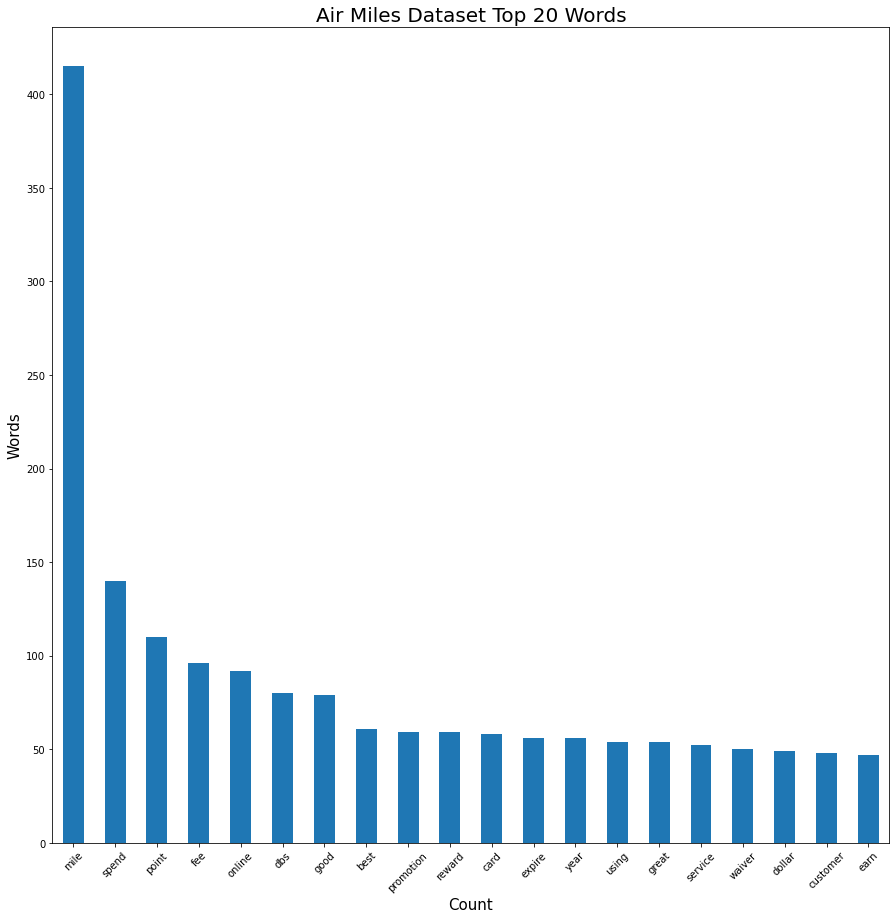

In [34]:
# Convert the top word count to a dataframe
top_words_miles = top_words(miles_sparse_matrix, 20).to_frame()

# Plot the top 20 words in a bar chart
miles_bar = top_words_miles.plot(kind = 'bar', figsize = (15,15), fontsize = 10, width = 0.5)

# Set the title, x & y labels and remove legend
miles_bar.set_title('Air Miles Dataset Top 20 Words', fontsize=20)
miles_bar.get_legend().remove()
miles_bar.set_ylabel('Words', fontsize=15)
miles_bar.set_xlabel('Count', fontsize=15)
plt.xticks(rotation=45);

In [35]:
# Lemmatize the 'title and selftext' column in the perfumes_df_cleaned dataset
miles_analyse_df['reviews_lemmatized'] = miles_analyse_df['reviews_no_stop'].apply(
    lambda x: lemmatizing(x))

# Concatenate all the words in the 'title_and_selftext_lemmatized' column to string
miles_analyse_df['reviews_string'] = miles_analyse_df['reviews_lemmatized'].apply(
    lambda x: ' '.join(x))

# Create a mask for the word cloud
miles_mask = np.array(Image.open('../image/Plane.png'))

# Generate a word cloud
wc = WordCloud(background_color="white", colormap="tab10", max_font_size=150, mask = miles_mask)

wcloud = wc.generate(' '.join(miles_analyse_df['reviews_string']))

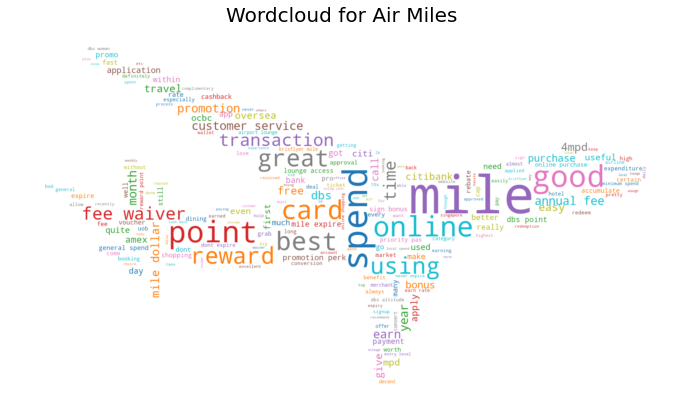

In [36]:
# Make figure to plot
plt.figure(figsize = (12,12))

# plot words
plt.imshow(wcloud, interpolation="bilinear")

# remove axes
plt.title("Wordcloud for Air Miles", fontsize = 20)

# remove axes
plt.axis("off")

# save chart as png
plt.savefig('../image/miles_wordcloud.png', transparent = True, bbox_inches = 'tight')

# show the result
plt.show()

## Sentiment Analysis Using BERT

We have managed to identify the key card features that customers are looking out for. However, we do not know whether the discussions were of a positive or negative sentiment. As such, we will perform sentiment analysis on these reviews by using BERT.

Code to install `pytorch` and `huggingface` transformers:

In [37]:
# pip install torch torchvision torchaudio
# pip install transformers

We will make use of the pretrained model found on huggingface. [(source)](https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment)

In [38]:
# Load the pretrained BERT model
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [39]:
# Create a function to get the sentiment score
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors = 'pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [40]:
# Perform sentiment analysis on the cashback dataset
cashback_expand_df['sentiment'] = cashback_expand_df['reviews'].apply(lambda x: sentiment_score(x))

# Display the dataset after the sentiment analysis
display(cashback_expand_df.head())

,credit_card_name,card_type,reviews,sentiment
0,standard-chartered-unlimited-cashback-credit-card,Cashback,['My first credit card. One of the best cards ...,5
1,standard-chartered-unlimited-cashback-credit-card,Cashback,'A 1.5% no frill cashback cards. What i like ...,4
2,standard-chartered-unlimited-cashback-credit-card,Cashback,'[Fee Waivers] 0 customer service. they will ...,1
3,standard-chartered-unlimited-cashback-credit-card,Cashback,"""Fast application and ease of usage. Look out...",4
4,standard-chartered-unlimited-cashback-credit-card,Cashback,'Super useful cashback card for basically any...,5


In [41]:
# Perform sentiment analysis on the cashback dataset
miles_expand_df['sentiment'] = miles_expand_df['reviews'].apply(lambda x: sentiment_score(x))

# Display the dataset after the sentiment analysis
display(miles_expand_df.head())

,credit_card_name,card_type,reviews,sentiment
121,dbs-altitude-visa-signature-card,Air Miles,['Used to be my go-to general miles card but n...,4
122,dbs-altitude-visa-signature-card,Air Miles,"'Great ""catch all"" miles card - use other 4MP...",5
123,dbs-altitude-visa-signature-card,Air Miles,'Love this card with no expiry date of the DB...,5
124,dbs-altitude-visa-signature-card,Air Miles,'[Others] This card is one of the best entry-...,5
125,dbs-altitude-visa-signature-card,Air Miles,'I am an advocate of DBS. Their customer serv...,5


Now that we have obtained an analysis of the reviews, we will be able to know which card has the best reviews and which cards have the worst. In order to make comparisons between 2 cards, we will need to calculate a aggregated score for these cards. In this case, we will use a benchmarking tool called the 'Net Promoter Score' (NPS).

In [42]:
# Combine cashback_expand_df and miles_expand_df into one dataset
combined_expand_df = pd.merge(cashback_expand_df, miles_expand_df, how = 'outer')

**Net Promoter Score**

NPS is a benchmarking tool for customer satisfaction. The NPS method gives insights about customer loyalty by measuring customers’ willingness to recommend a business to a friend or acquaintance.

NPS differs from other related benchmarks, such as the customer satisfaction score, by indicating a customer’s general sentiment about a brand as opposed to their opinion on particular interactions or purchases. Because of this, it crops up frequently in discussions about customer experience.

In addition, net promoter score is a standard benchmark used by companies worldwide. This makes it a good way for businesses to gauge their performance as compared to their competitors. [(source)](https://www.salesforce.com/eu/learning-centre/customer-service/calculate-net-promoter-score/#:~:text=Net%20promoter%20score%20helps%20businesses,revenue%20through%20referrals%20and%20upsells.)

Usually, the NPS is calculated on a scale of 1 - 10, with score 0-6 being classified as 'Detractors', 7-8 being classified as 'Passives' and 9-10 being classified as 'Promoters'. To calculate the net promoter score, the percentage of detractors is simply deducted from from the percentage of promoters. The worst possible score - i.e., the score that would be achieved if every customer was a detractor, is -100. The best is 100. [(source)](https://www.salesforce.com/eu/learning-centre/customer-service/calculate-net-promoter-score/#:~:text=Net%20promoter%20score%20helps%20businesses,revenue%20through%20referrals%20and%20upsells.) Any score above 0 is considered good, whilst any NPS score over +50 is considered excellent. Organizations that score over the +70 mark will be providing the best customer experience.[(source)](https://kwiksurveys.com/blog/feedback/net-promoter-score-how-to-calculate-nps)

However in our case, sentiment analysis is being performed on a scale of 1-5, thus we will 1-3 will be classified as 'Detractors', 4 will be classified as 'Passives' and 5 will be classified as 'Promoters.

**1. Net Promoter Score for Cashback cards**

In [43]:
# Save all the cashback cards into a list
cashback_names = cashback_expand_df['credit_card_name'].unique()

# Set the scores for promoters, passives and detractors
Promoters = [5]
Passives = [4]
Detractors = [1,2,3]

# Create a dictionary to store the card names and the NPS
cashback_cards_nps = {}

for cards in cashback_names:
    # Filter dataset for the individual cards
    individual_card = cashback_expand_df[cashback_expand_df['credit_card_name']== cards]
    
    # Calculate the total number of promoters and detractors
    card_promoters = round(individual_card[individual_card['sentiment'].isin(Promoters)].shape[0]/individual_card.shape[0]*100,0)
    card_detractors = round(individual_card[individual_card['sentiment'].isin(Detractors)].shape[0]/individual_card.shape[0]*100,0)
    
    # Calculate the NPS
    card_nps = card_promoters - card_detractors
    
    # Save the NPS in a dictionary
    cashback_cards_nps[cards]={}
    cashback_cards_nps[cards]['no_of_reviews'] = individual_card.shape[0]
    cashback_cards_nps[cards]['net_promoter_score'] = card_nps
    

# Store the results in a dataframe
cashback_cards_nps_df = pd.DataFrame.from_dict(cashback_cards_nps, orient = 'index')
display(cashback_cards_nps_df.head())

,no_of_reviews,net_promoter_score
standard-chartered-unlimited-cashback-credit-card,121,20.0
uob-one-card,113,0.0
posb-everyday-cashback,146,8.0
amex-true-cashback-card,48,17.0
ocbc-ntuc-plus-visa-credit-card,19,10.0


Let's take a look at the findings. We will sort the scores by the Net Promoter Score followed by the number of reviews. 

**1.1. Cashback cards with the highest NPS scores**

In [44]:
# Sort the dataset by net promoter score followed by the total number of reviews
display(cashback_cards_nps_df.sort_values(['net_promoter_score', 'no_of_reviews'], ascending = [False, False]).head(20))

,no_of_reviews,net_promoter_score
uob-absolute-cashback-card,1,100.0
maybank-evibes-card,1,100.0
cimb-world-mastercard,1,100.0
uob-evol-card,1,100.0
cimb-awsm-card,4,50.0
ocbc-plus-visa-card,9,22.0
standard-chartered-unlimited-cashback-credit-card,121,20.0
amex-true-cashback-card,48,17.0
ocbc-ntuc-plus-visa-credit-card,19,10.0
ocbc-cashflo-credit-card,10,10.0


Seems like there are a few cards with a net promoter score of 100 but there is only 1 review for these cards. If we filter out these cards, the top card will be the OCBC Plus Visa Card followed by the Standard Chartered Unlimited Cashback Credit Card.

**1.2. Cashback cards with the lowest NPS scores**

Let's take a look at the cards that has the lowest NPS.

In [45]:
# Sort the dataset by net promoter score followed by the total number of reviews
display(cashback_cards_nps_df.sort_values(['net_promoter_score', 'no_of_reviews'], ascending = [True, False]).head(20))

,no_of_reviews,net_promoter_score
ocbc-frank-credit-card,17,-53.0
citi-cash-back-plus-card,6,-50.0
cimb-visa-signature,27,-44.0
citi-cash-back-card,13,-39.0
dbs-live-fresh-cashback,71,-31.0
ocbc-365-credit-card,101,-29.0
ocbc-great-eastern-cashflo-credit-card,4,-25.0
citi-smrt-card,36,-14.0
uob-one-card,113,0.0
dbs-safra-card,4,0.0


By looking at this, the OCBC Frank Credit Card has the worst Net Promoter scre followed by the Citi Cash Back Plus Card. Based on the above, we have noted tha there are quite a lot of credit cards that have very little reviews. Thus, we will exclude the cards that have less than 5 reviews when we make the recommendations later.

**2. Net Promoter Scores for miles card**

In [46]:
# Save all the miles cards into a list
miles_names = miles_expand_df['credit_card_name'].unique()

# Set the scores for promoters, passives and detractors
Promoters = [5]
Passives = [4]
Detractors = [1,2,3]

# Create a dictionary to store the card names and the NPS
miles_cards_nps = {}

for cards in miles_names:
    # Filter dataset for the individual cards
    individual_card = miles_expand_df[miles_expand_df['credit_card_name']== cards]
    
    # Calculate the total number of promoters and detractors
    card_promoters = round(individual_card[individual_card['sentiment'].isin(Promoters)].shape[0]/individual_card.shape[0]*100,0)
    card_detractors = round(individual_card[individual_card['sentiment'].isin(Detractors)].shape[0]/individual_card.shape[0]*100,0)
    
    # Calculate the NPS
    card_nps = card_promoters - card_detractors
    
    # Save the NPS in a dictionary
    miles_cards_nps[cards]={}
    miles_cards_nps[cards]['no_of_reviews'] = individual_card.shape[0]
    miles_cards_nps[cards]['net_promoter_score'] = card_nps
    
# Store the results in a dataframe
miles_cards_nps_df = pd.DataFrame.from_dict(miles_cards_nps, orient = 'index')
display(miles_cards_nps_df.head())

,no_of_reviews,net_promoter_score
dbs-altitude-visa-signature-card,51,13.0
dbs-womans-world-card,19,16.0
citi-rewards-credit-card,25,28.0
uob-preferred-platinum-visa-card,7,-14.0
citi-premiermiles-visa-card,37,-27.0


Let's take a look at the findings. We will sort the scores by the Net Promoter Score followed by the number of reviews.

**2.1. Air Miles cards with the highest NPS scores**

In [47]:
# Sort the dataset by net promoter score followed by the total number of reviews
display(miles_cards_nps_df.sort_values(['net_promoter_score', 'no_of_reviews'], ascending = [False, False]).head(20))

,no_of_reviews,net_promoter_score
citi-rewards-credit-card,25,28.0
uob-prvi-miles-visa-card,10,20.0
dbs-womans-world-card,19,16.0
dbs-altitude-visa-signature-card,51,13.0
amex-singapore-airlines-krisflyer-credit-card,19,5.0
amex-singapore-airlines-krisflyer-ascend-credit-card,2,0.0
amex-platinum-card,1,0.0
dbs-womans-card,1,0.0
dbs-black-visa-card,1,0.0
amex-platinum-credit-card,1,0.0


Based on the above, the Citibank Rewards Credit Card has best NPS followed by the UOB  Pri Miles VIsa Card and the DBS Womans World Card. Let's look at the cards with the lowest NPS scores.

**2.2. Air Miles cards with the lowest NPS scores**

In [48]:
# Sort the dataset by net promoter score followed by the total number of reviews
display(miles_cards_nps_df.sort_values(['net_promoter_score', 'no_of_reviews'], ascending = [True, False]).head(20))

,no_of_reviews,net_promoter_score
amex-capitacard,2,-100.0
citi-premiermiles-visa-card,37,-27.0
ocbc-90-degrees-n-mastercard,13,-23.0
ocbc-titanium-rewards-card,10,-20.0
uob-preferred-platinum-visa-card,7,-14.0
hsbc-revolution-credit-card,16,-6.0
amex-singapore-airlines-krisflyer-ascend-credit-card,2,0.0
amex-platinum-card,1,0.0
dbs-womans-card,1,0.0
dbs-black-visa-card,1,0.0


The Amex Capitacard has the lowest possible score of -100, but there were only 2 reviews. This means that the two users who had left the review would most probably have a bad experience using the cards. The card with the next worst NPS score is the Citi Premiermiles Visa Card followed by the OCBC 90 Degrees N Mastercard. Similarly, we will exclude the cards that have less than 5 reviews when we make our recommendations.

Now that we have completed the EDA analysis and calculated the Net Promoter Scores for the cards, we will start to build our credit card recommender.

**3. Export Datasets**

In [49]:
cashback_expand_df.to_csv('../dataset/2.cashback_expand_df.csv')
miles_expand_df.to_csv('../dataset/2.miles_expand_df.csv')
combined_expand_df.to_csv('../dataset/2.combined_expand_df.csv')
miles_cards_nps_df.to_csv('../dataset/2.miles_cards_nps_df.csv')
cashback_cards_nps_df.to_csv('../dataset/2.cashback_cards_nps_df.csv')
cashback_analyse_df.to_csv('../dataset/2.cashback_analyse_df.csv')
miles_analyse_df.to_csv('../dataset/2.miles_analyse_df.csv')
combined_analyse_df.to_csv('../dataset/2.combined_analyse_df.csv')

We will continue the rest of the analysis in a separate workbook. Please refer to **"3. Modelling"** for the portion on modelling.